<a href="https://colab.research.google.com/github/SHASHIKATSHEGOKAR/AB-Testing-in-Python/blob/main/AB_testing_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [ ]:
df = pd.read_csv('ADData.csv',parse_dates=['date'])

In [ ]:
print (df.shape)

(1243, 8)


In [ ]:
df.head(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,ad_success
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,0,6,1,0
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,0,6,1,1
20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,0,6,1,0
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,1,6,0,1
27,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,0,6,1,0


In [ ]:
total_nulls = df.isnull().sum()
print('Null values')
print('total_nulls')
print('')

Null values
total_nulls



In [ ]:
ad_success =[]
for x, y in zip(df.yes, df.no):
    if (x == 1) and (y == 0):
        ad_success.append(1)
    elif (x == 0) and (y == 1):
        ad_success.append(0)
    else:
        ad_success.append('no_response')
df['ad_success'] = ad_success
df = df.loc[~df.ad_success.isin(['no_response'])]
df = df.drop(['yes', 'no'], axis = 1)

In [ ]:
device_list_codified = []
for x in df.device_make:
    if 'Samsung' in x:
        device_list_codified.append(1)
    elif 'iPhone' in x:
        device_list_codified.append(2)
    else:
        device_list_codified.append(0)
df.device_make = device_list_codified

browser_list_codified = []
for x in df.browser:
    if 'Chrome' in x:
        browser_list_codified.append(1)
    elif 'Safari' in x:
        browser_list_codified.append(2)
    else:
        browser_list_codified.append(0)
df.browser = browser_list_codified

del ad_success, device_list_codified, browser_list_codified

In [ ]:
print ('# observations: {}'. format(df.shape[0]))
print ('# variables: {}'. format(df.shape[1]))
df.head()

# observations: 1243
# variables: 8


,auction_id,experiment,date,hour,device_make,platform_os,browser,ad_success
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,0,6,1,0
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,0,6,1,1
20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,0,6,1,0
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,1,6,0,1
27,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,0,6,1,0


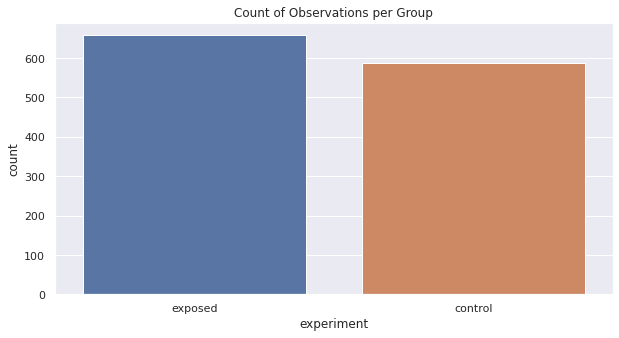

In [ ]:
sns.set(rc={'figure.figsize':(10,5)})
sns.countplot(x='experiment', data=df)
plt.title('Count of Observations per Group')
plt.show()
plt.close()

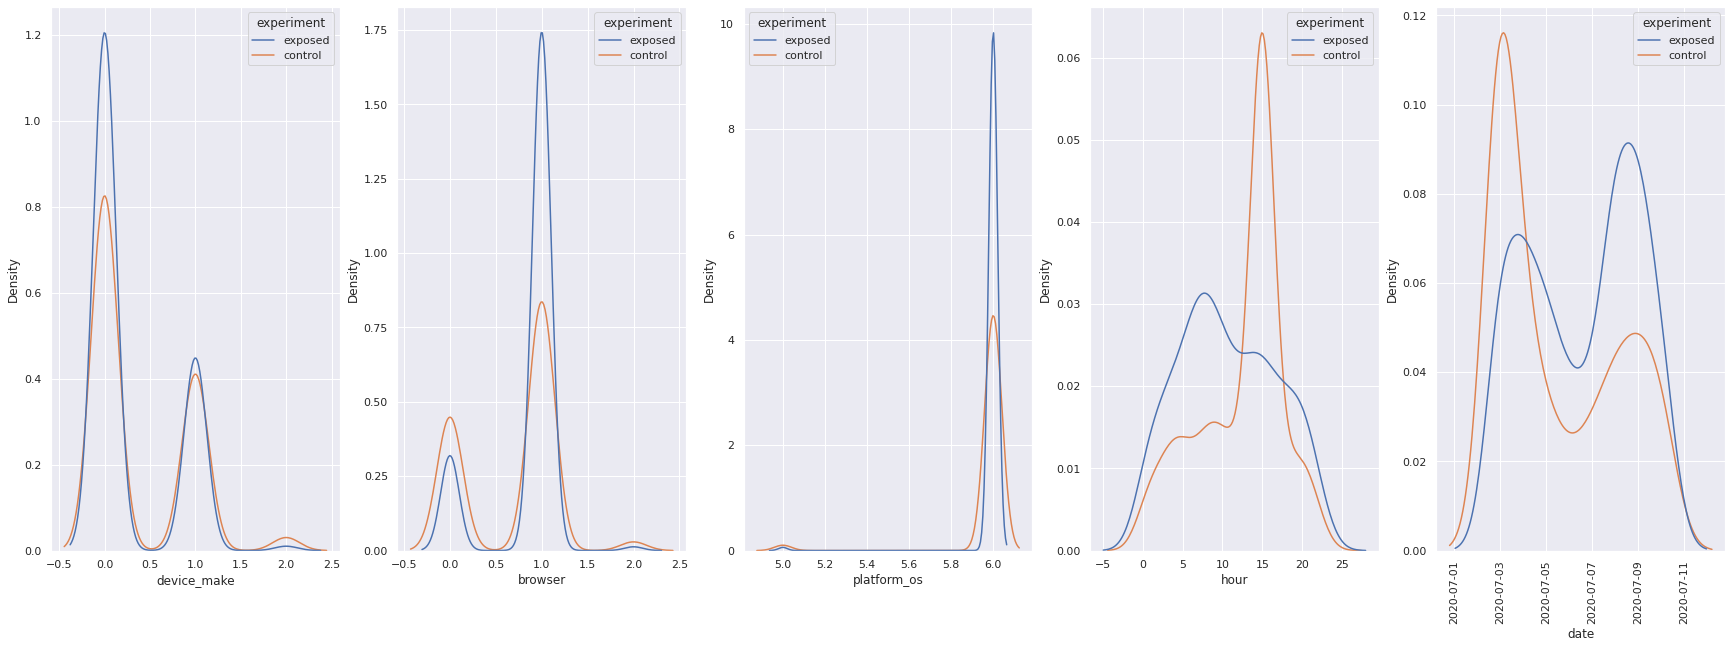

In [ ]:
sns.set(rc={'figure.figsize':(30,10)})
fig, ax = plt.subplots(1,5)
sns.kdeplot(x='device_make', hue='experiment', data=df, ax=ax[0])
sns.kdeplot(x='browser', hue='experiment', data=df, ax=ax[1])
sns.kdeplot(x='platform_os', hue='experiment', data=df, ax=ax[2])
sns.kdeplot(x='hour', hue='experiment', data=df, ax=ax[3])
sns.kdeplot(x='date', hue='experiment', data=df, ax=ax[4])
plt.xticks(rotation=90)
plt.show()
plt.close()

In [ ]:
df_control = df[df.experiment =='control']
df_exposed = df[df.experiment =='exposed']

In [ ]:
mean_success_control = df_control.ad_success.mean()
mean_success_exposed = df_exposed.ad_success.mean()

In [ ]:
print('Ad Success Control group {}%'.format((mean_success_control*100).round(2)))
print('Ad Success Exposed group {}%'.format((mean_success_exposed*100).round(2)))

Ad Success Control group 45.05%
Ad Success Exposed group 46.88%


In [ ]:
# Computing the difference (improvement) we want to obtain. From 45% 'ad_success' to 50%
effect_size = sms.proportion_effectsize(0.45, 0.50)

In [ ]:
# Computing the needed sample size (per group) to ensure that we capture siginificant differences
    # Effect_size = The difference you want to observe
    # Power = The probability that we will capture an existing difference. 0.8 is standard practice
    # Alpha = alpha value for your desired statistical significance
required_n = np.ceil(sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1))

In [ ]:
# Printing required sample
print(f'Number of observations needed by group: {int(required_n)}')
print(f'Number of total observations on dataset: {df.shape[0]}')
print('')

Number of observations needed by group: 1565
Number of total observations on dataset: 1243



In [ ]:
# Counting successes on each group
ad_succes_count = [df_control.ad_success.sum(), df_exposed.ad_success.sum()]

In [ ]:
# Counting observations on each group
obs_count = [df_control.ad_success.count(), df_exposed.ad_success.count()]

In [ ]:
# Computing p-value of the ad_success distribution
z_stat, pval = proportions_ztest(ad_succes_count, nobs=obs_count)

In [ ]:
# Computing 95% confidence intervals
(l_ci_con, l_ci_exp), (u_ci_con, u_ci_exp) = proportion_confint(ad_succes_count, nobs=obs_count, alpha=0.05)

In [ ]:
# Prinitng results
print('The p-value of ad_success is {}'.format(pval.round(4)))
print(f'The 95% CI for ad_success on the control group is [{l_ci_con.round(4)}, {u_ci_con.round(4)}]')
print(f'The 95% CI for ad_success on the exposed group is [{l_ci_exp.round(4)}, {u_ci_exp.round(4)}]')

The p-value of ad_success is 0.5185
The 95% CI for ad_success on the control group is [0.4102, 0.4908]
The 95% CI for ad_success on the exposed group is [0.4306, 0.507]
